In [1]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import pytorch_lightning as pl
import time
import copy

from torchsummary import summary
from torch.utils.data.sampler import SequentialSampler
from PIL import Image
from sklearn.model_selection import train_test_split

In [4]:
TORCH_DEVICE = 'mps' # there is currently a bug: https://github.com/pytorch/pytorch/issues/78915
# TORCH_DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CKPT_PATH = '../../Faster_R-CNN_GZ2/pre_trained_models/Zoobot_Resnet_Torchvision/'
CKPT_NAME = 'epoch=20-step=6552.ckpt'

DATA_PATH = '../Data/'
IMAGE_PATH = DATA_PATH + 'real_pngs/'

LOG_DIR = './logs/train'
MODEL_SAVE_PATH = './checkpoints/'
MODEL_NAME = 'Zoobot_Clump_Classifier'

# using typical split of 80:10:10
SIZE_OF_VALIDATION_SET = 0.1
SIZE_OF_TEST_SET = 0.1

BATCH_SIZE = 8

RESIZE_SIZE = 224   # Zoobot, as pretrained, expects 224x224 images
IS_COLOUR = True
CROP_SCALE_BOUNDS = (0.7, 0.8)
CROP_RATIO_BOUNDS = (0.9, 1.1)


In [5]:
print(TORCH_DEVICE)

mps


In [6]:
# Creating the datasets
df = pd.read_csv(DATA_PATH + 'clumps.csv')
df = df.sample(frac=0.01)

# Randomly divide into train and validation sets using sklearn
# train_df, hidden_df = train_test_split(df, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET)
# val_df, test_df = train_test_split(hidden_df, test_size=SIZE_OF_TEST_SET / (SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET))
train_df, val_df = train_test_split(df, test_size=SIZE_OF_VALIDATION_SET + SIZE_OF_TEST_SET, random_state=42)

print('Training subjects: {}'.format(len(train_df)))
print('Val subjects: {}'.format(len(val_df)))
# print('Test subjects: {}'.format(len(test_df)))
# print('Sum: {}, of {} in total.'.format(len(train_df)+len(val_df)+len(test_df), len(df)))
print('Sum: {}, of {} in total.'.format(len(train_df)+len(val_df), len(df)))

print('Balancing:')
print('==========')
for df_name, df_temp in zip(['total', 'Train', 'Validation'], [df, train_df, val_df]):
    test = df_temp['label'].fillna(-1).value_counts()
    label_0 = test[0]
    label_1 = test[1]
    ratio_0 = label_0 / (label_0 + label_1) * 100
    ratio_1 = label_1 / (label_0 + label_1) * 100
    print('{} : w/o clumps: {} ({:4.2f}%) - clumpy: {} ({:4.2f}%)'.format(df_name, label_0, ratio_0, label_1, ratio_1))

Training subjects: 364
Val subjects: 92
Sum: 456, of 456 in total.
Balancing:
total : w/o clumps: 262 (57.46%) - clumpy: 194 (42.54%)
Train : w/o clumps: 210 (57.69%) - clumpy: 154 (42.31%)
Validation : w/o clumps: 52 (56.52%) - clumpy: 40 (43.48%)


In [7]:
# Data augmentation and normalization for training
def get_transform(train):
    augs = []
    
    if train:
        augs.append(transforms.RandomResizedCrop(
            RESIZE_SIZE, 
            scale=CROP_SCALE_BOUNDS,
            ratio=CROP_RATIO_BOUNDS,
            interpolation=transforms.InterpolationMode.BILINEAR)
        )
        augs.append(transforms.RandomHorizontalFlip(0.5))
        augs.append(transforms.RandomRotation(
            degrees=90., 
            interpolation=transforms.InterpolationMode.BILINEAR)
        )

    # augs.append(transforms.Resize(RESIZE_SIZE))
    augs.append(transforms.CenterCrop(RESIZE_SIZE))
    # augs.append(transforms.PILToTensor())
    # augs.append(transforms.ConvertImageDtype(torch.float))
    augs.append(transforms.ToTensor())
    
    return transforms.Compose(augs)

In [8]:
# Dataset class and defined transformations
import SDSSGalaxyDataset
image_datasets = {}

image_datasets['train'] = SDSSGalaxyDataset.SDSSGalaxyDatasetClassification(
    dataframe=train_df,
    image_dir=IMAGE_PATH,
    colour=IS_COLOUR,
    transforms=get_transform(train=True)
)
image_datasets['val'] = SDSSGalaxyDataset.SDSSGalaxyDatasetClassification(
    dataframe=val_df,
    image_dir=IMAGE_PATH,
    colour=IS_COLOUR,
    transforms=get_transform(train=False)
)

dataloaders_dict = {x: torch.utils.data.DataLoader(
    image_datasets[x], 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4
) for x in ['train', 'val']}

print("Count: {} are training and {} validation".format(len(image_datasets['train']), len(image_datasets['val'])))

Count: 364 are training and 92 validation


In [9]:
images, labels = next(iter(dataloaders_dict['val']))
images = list(image.to(TORCH_DEVICE) for image in images)
labels = list(label.to(TORCH_DEVICE) for label in labels)

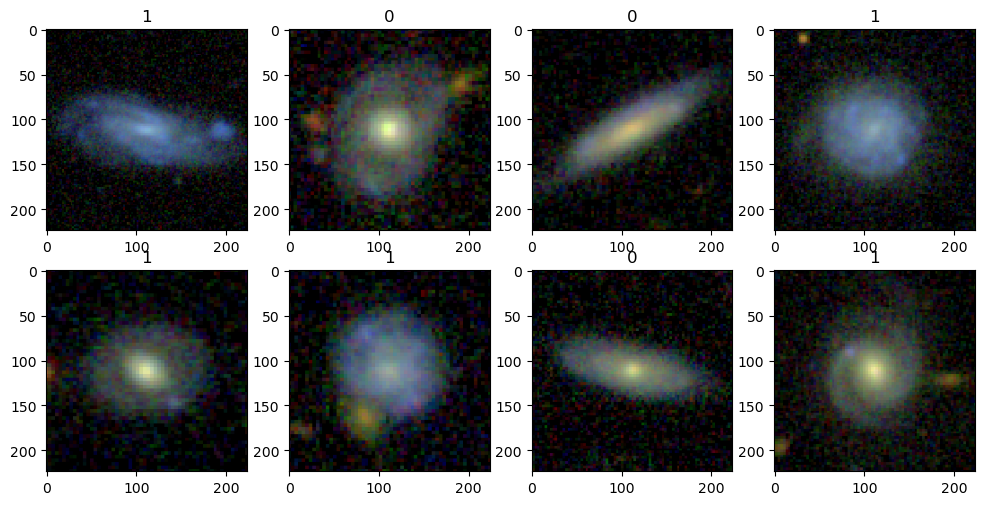

In [10]:
plt.figure(figsize=(12, 12))
for i in range(BATCH_SIZE):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
    plt.title(labels[i].cpu().numpy().astype(np.int32))

In [11]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def create_model(feature_extract=False):
    # Get Zoobot model and weights - Resnet
    # needs to be model with head, otherwise the checkpoint won't fit
    import define_model
    zoobot = define_model.ZoobotLightningModule(
        output_dim=34,
        question_index_groups=['idx1', 'idx2'],
        include_top=True,
        channels=3,
        use_imagenet_weights=False,
        always_augment=True,
        dropout_rate=0.2,
        architecture_name='resnet_torchvision'
    )
    checkpoint = torch.load(CKPT_PATH+CKPT_NAME, map_location=torch.device(TORCH_DEVICE))
    zoobot.load_state_dict(checkpoint['state_dict'])

    # select layers for feature map
    model = zoobot.model[0][0:10]
    set_parameter_requires_grad(model, feature_extract)
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.25),
        nn.Linear(in_features=2048, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=2),
    )

    return model

In [20]:
def train_model(model, dataloaders, criterion, optimizer, tb_writer=None, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(TORCH_DEVICE)
                labels = labels.to(TORCH_DEVICE)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        # plot_grad_flow(model.named_parameters())
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = float(running_corrects) / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('Running corrects: {} No. of samples: {}'.format(running_corrects, len(dataloaders[phase].dataset)))

            if tb_writer is not None:
                tb_writer.add_scalar('Loss/{}'.format(phase), epoch_loss, epoch)
                tb_writer.add_scalar('Accuracy/{}'.format(phase), epoch_acc, epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

        # save checkpoint
        model_save_path = MODEL_SAVE_PATH + MODEL_NAME + '_' + str(epoch+1) + '.pth'
        torch.save(model.state_dict(), model_save_path)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # close Tensorboard Writer
    if tb_writer is not None:
        tb_writer.close()
    
    return model, val_acc_history

In [21]:
# get the model
zoobot_clumps = create_model(feature_extract=False)

# move model to the right device
zoobot_clumps = zoobot_clumps.to(TORCH_DEVICE)

# Gather the parameters to be optimized/updated in this run. 
params_to_update = zoobot_clumps.parameters()

# Observe that all parameters are being optimized
# optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(params_to_update, lr=0.0001, weight_decay=0.00005)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

/opt/homebrew/Caskroom/miniforge/base/envs/env_torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/env_torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
# initialise Tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir=LOG_DIR)

In [ ]:
# Train and evaluate
zoobot_clumps, hist = train_model(
    zoobot_clumps, 
    dataloaders_dict, 
    criterion, 
    optimizer,
    tb_writer=writer,
    num_epochs=10
)

In [ ]:
for name, parameter in zoobot_clumps.named_parameters():
    if parameter.requires_grad:
        print(name)

In [ ]:
print(zoobot_clumps)

In [ ]:
from torchsummary import summary
summary(zoobot_clumps, (3, 224, 224))

In [114]:
# create model
loaded_model = create_model(feature_extract=False)

# load checkpoint
last_epoch = 36
model_save_path = MODEL_SAVE_PATH + MODEL_NAME + '_' + str(last_epoch) + '.pth'
loaded_model.load_state_dict(torch.load(
    model_save_path,
    map_location=torch.device(TORCH_DEVICE)
))

# put the model in evaluation mode
loaded_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [115]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders_dict['val']:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = loaded_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the {} test images: {} %'.format(len(image_datasets['val']), 100 * correct // total))

Accuracy of the network on the 92 test images: 81 %


In [116]:
N = 16 # number of galaxies to be plotted
grid_n = np.rint(np.sqrt(N)).astype(np.int32)
SCORE_THRESHOLD = 0.5

label_text = {
    0: 'w/o clumps',
    1: 'clumpy',
}

image_list = []
label_list = []
prediction_list = []
probs_list = []

data_iter = iter(dataloaders_dict['val'])
for n in range(0, N, BATCH_SIZE):
    images, labels = next(data_iter)
    image_list.append(images)
    label_list.append(labels)

    outputs = loaded_model(images)
    _, predicted = torch.max(outputs.data, 1)
    prediction_list.append(predicted)

    probs = torch.nn.functional.softmax(outputs, dim=1)
    conf, classes = torch.max(probs, 1)
    probs_list.append(conf)

images = [item for sublist in image_list for item in sublist]
labels = [item for sublist in label_list for item in sublist]
predictions = [item for sublist in prediction_list for item in sublist]
probs = [item for sublist in probs_list for item in sublist]

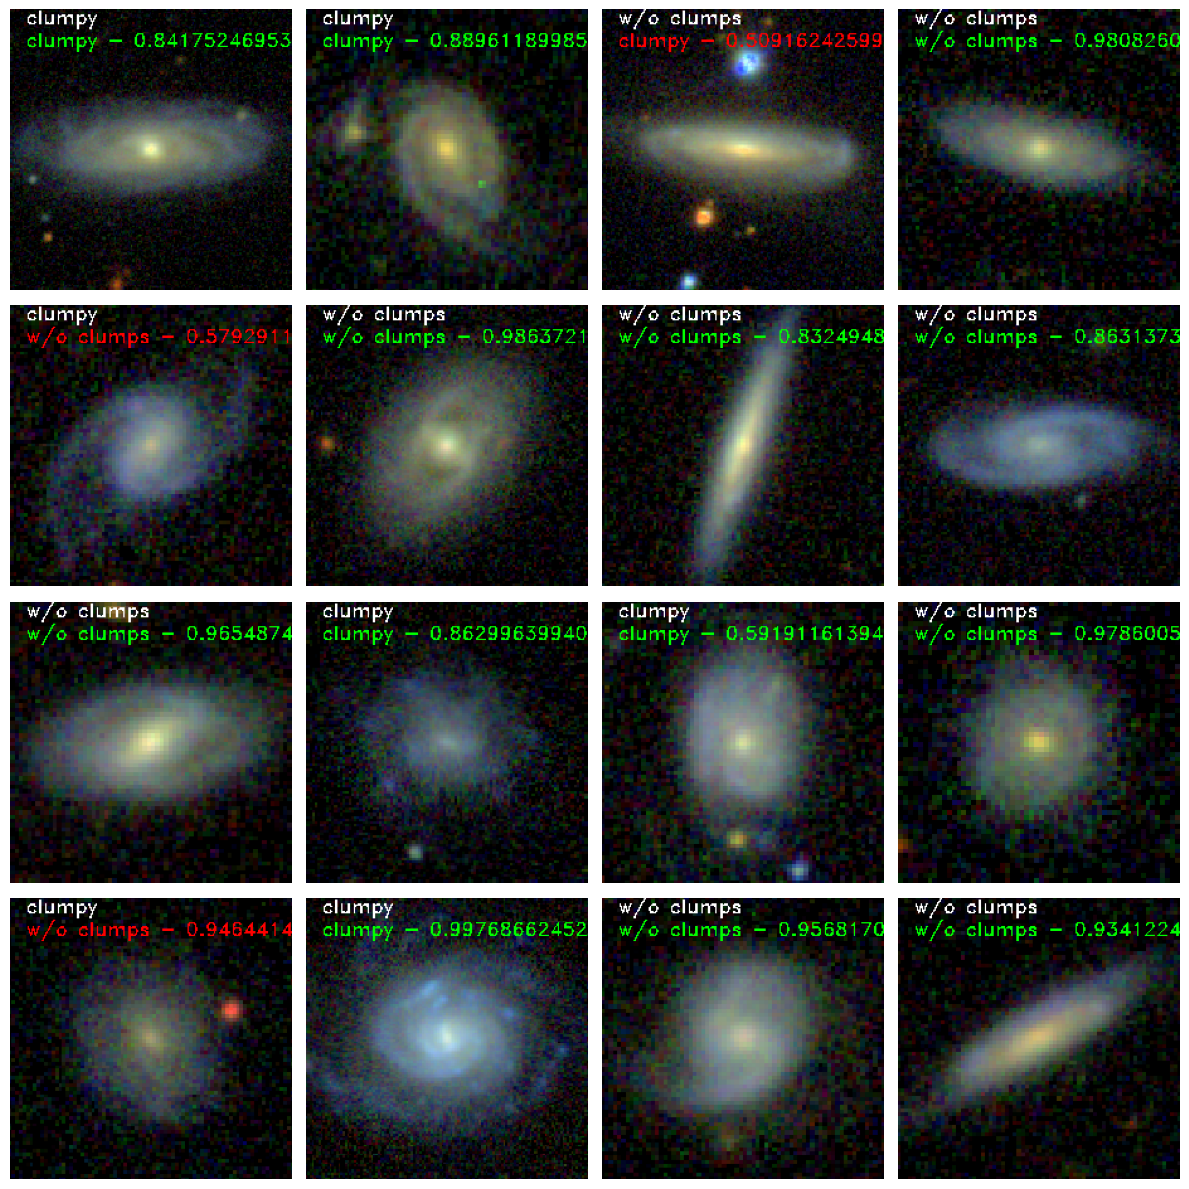

In [117]:
fig, axs = plt.subplots(grid_n, grid_n, figsize=(12,12), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i in range(N):
    sample = images[i].permute(1, 2, 0).cpu().numpy()
    sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR) # the image is in RGB, convert to BGR for cv2 annotations
    cv2.putText(sample, 
        label_text[labels[i].tolist()],
        org=(12, 12),
        fontFace=cv2.FONT_HERSHEY_DUPLEX, 
        fontScale=0.5,
        color=(255, 255, 255),
        thickness=1
    )
    if labels[i] == predictions[i]:
        text_color = (0, 255, 0)
    else:
        text_color = (0, 0, 255)
    cv2.putText(sample, 
        label_text[predictions[i].tolist()] + ' - ' + str(probs[i].tolist()),
        org=(12, 30),
        fontFace=cv2.FONT_HERSHEY_DUPLEX, 
        fontScale=0.5,
        color=text_color,
        thickness=1
    )
    axs[i].imshow(sample[:, :, ::-1])
    axs[i].axis('off')

plt.tight_layout()